Customer Revenue Analysis

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Quickstart from Kaggle

In [ ]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [ ]:
df_train = load_df('train.csv')

Loaded train.csv. Shape: (903653, 55)


In [ ]:
df_train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.t

Graphs of some of the data features distributions

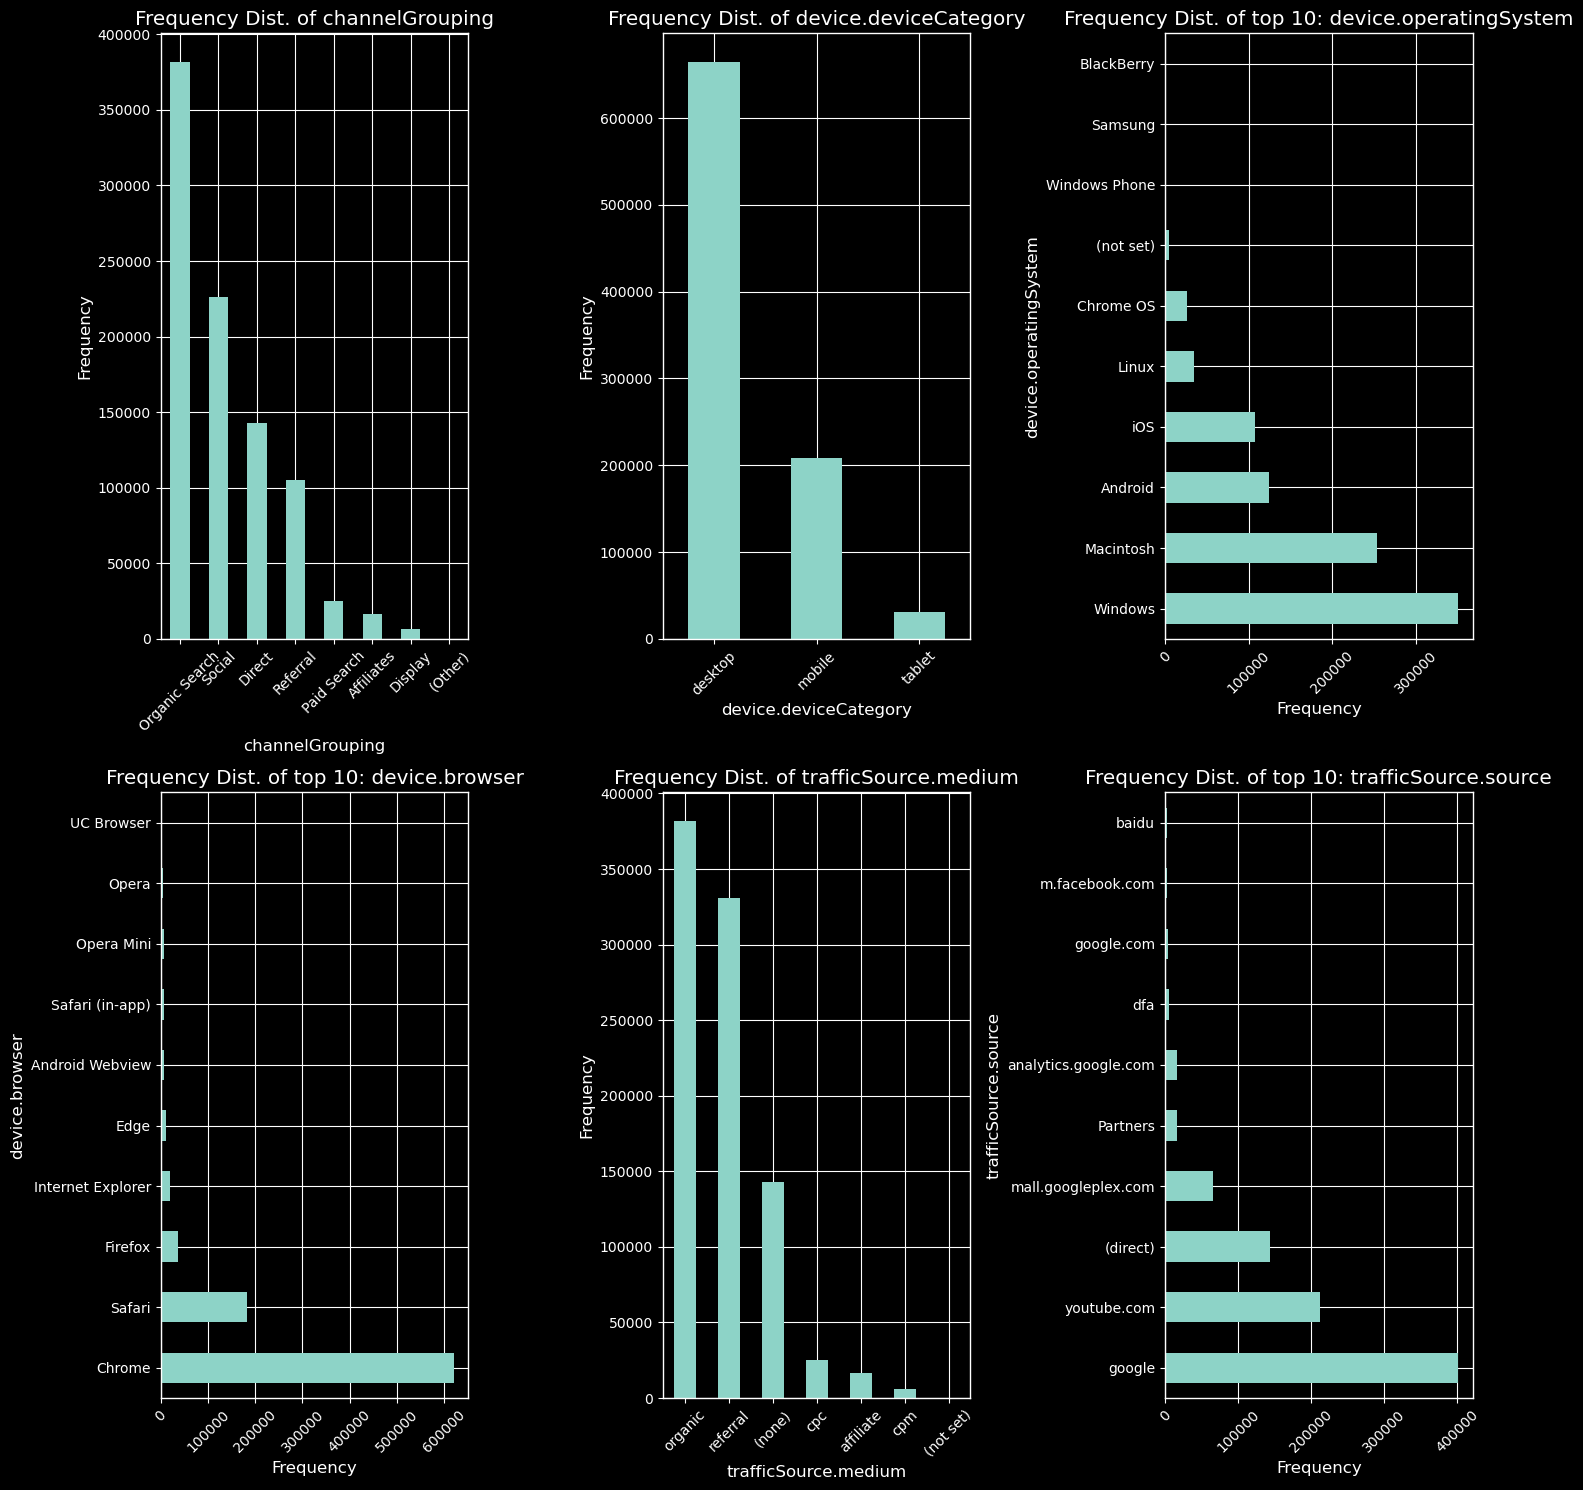

In [ ]:
categorical_cols = ['channelGrouping', 'device.deviceCategory','device.operatingSystem','device.browser',
                    'trafficSource.medium','trafficSource.source']

fig, axes = plt.subplots(2, 3, figsize=(15,15))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    cat_counts = df_train.groupby(col).size().sort_values(ascending=False)

    if len(cat_counts) < 10:
        cat_counts.plot(kind='bar',ax=ax)
        ax.set_title(f"Frequency Dist. of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.tick_params(axis='x', rotation=45)
    else:
        cat_counts = df_train.groupby(col).size().sort_values(ascending=False).head(10)
        cat_counts.plot(kind='barh',ax=ax)
        ax.set_title(f"Frequency Dist. of top 10: {col}")
        ax.set_xlabel("Frequency")
        ax.set_ylabel(col)
        ax.tick_params(axis='x',rotation=45)

plt.style.use('dark_background')
plt.tight_layout()
plt.show()

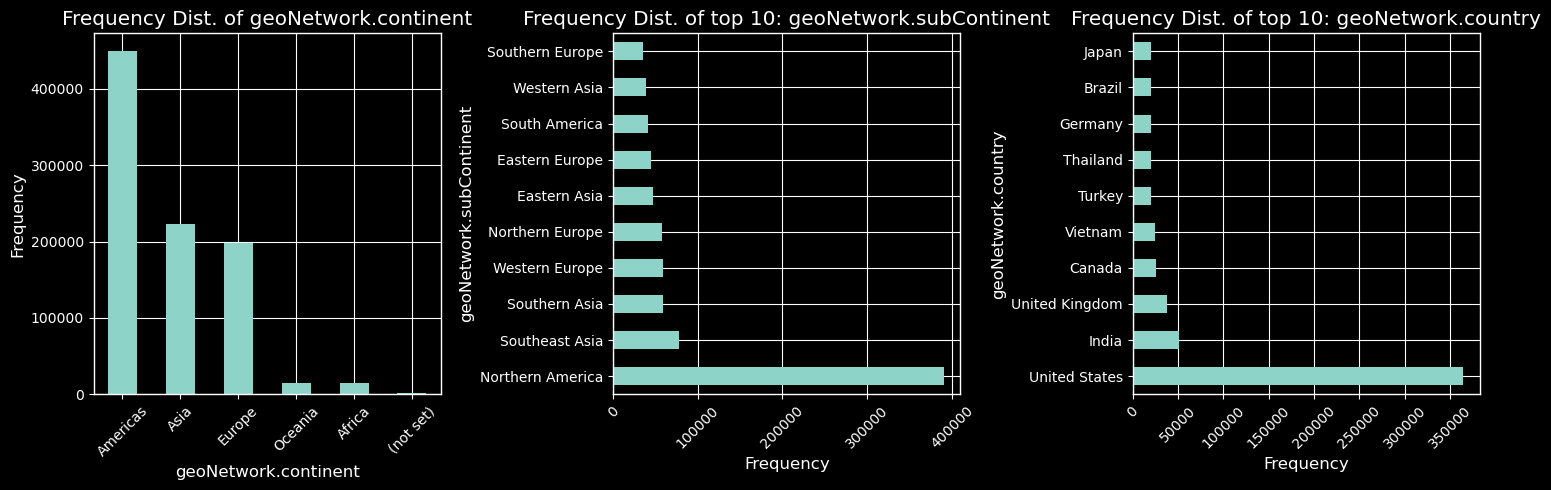

In [ ]:
geo_cats = ['geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country']

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.flatten()

for i, col in enumerate(geo_cats):
    ax = axes[i]
    cat_counts = df_train.groupby(col).size().sort_values(ascending=False)

    if len(cat_counts) < 10:
        cat_counts.plot(kind='bar',ax=ax)
        ax.set_title(f"Frequency Dist. of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.tick_params(axis='x', rotation=45)
    else:
        cat_counts = df_train.groupby(col).size().sort_values(ascending=False).head(10)
        cat_counts.plot(kind='barh',ax=ax)
        ax.set_title(f"Frequency Dist. of top 10: {col}")
        ax.set_xlabel("Frequency")
        ax.set_ylabel(col)
        ax.tick_params(axis='x',rotation=45)

plt.tight_layout()
plt.show()

Target Comp.

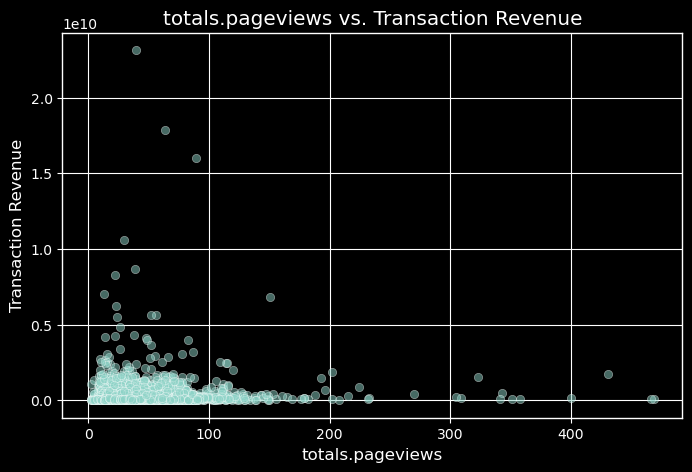

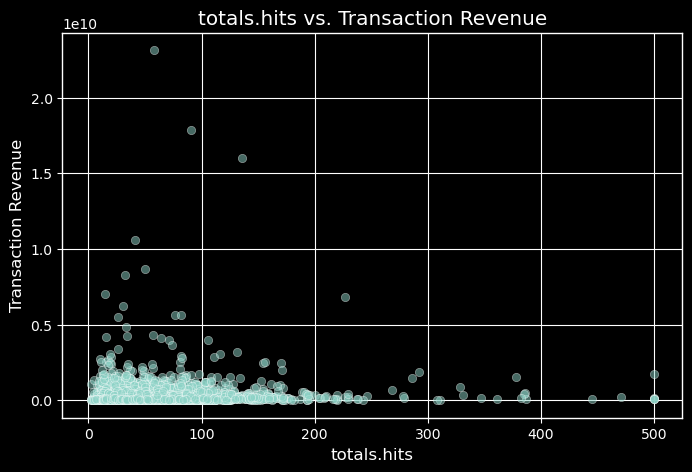

In [ ]:
rev_to_numeric = df_train.copy()
rev_to_numeric['totals.transactionRevenue'] = pd.to_numeric(rev_to_numeric['totals.transactionRevenue'], errors='coerce')
rev_to_numeric['totals.pageviews'] = pd.to_numeric(rev_to_numeric['totals.pageviews'], errors='coerce')
rev_to_numeric['totals.hits'] = pd.to_numeric(rev_to_numeric['totals.hits'], errors='coerce')
features = ['totals.pageviews', 'totals.hits']

for feature in features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x=rev_to_numeric[feature],
        y=rev_to_numeric['totals.transactionRevenue'],
        alpha=0.5
    )
    plt.title(f"{feature} vs. Transaction Revenue")
    plt.xlabel(feature)
    plt.ylabel("Transaction Revenue")
    plt.show()

Cleaning up

In [ ]:
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].fillna(0).astype(float)
df_train['totals.hits'] = df_train['totals.hits'].fillna(0).astype(float)
df_train['totals.pageviews'] = df_train['totals.pageviews'].fillna(0).astype(float)
df_train['visitNumber'] = df_train['visitNumber'].fillna(0).astype(int)
df_train['visitStartTime'] = df_train['visitStartTime'].fillna(0).astype(int)
df_train['device.isMobile'] = df_train['device.isMobile'].astype(int)
df_train['trafficSource.isTrueDirect'] = df_train['trafficSource.isTrueDirect'].fillna(False).astype(int)
df_train['trafficSource.adwordsClickInfo.isVideoAd'] = df_train['trafficSource.adwordsClickInfo.isVideoAd'].fillna(False).astype(int)
df_train['totals.bounces'] = df_train['totals.bounces'].fillna(0).astype(int)

Label or Mean Encoding

Mean Encoding Cite: https://www.kaggle.com/code/vprokopev/mean-likelihood-encodings-a-comprehensive-study

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

In [ ]:
categorical_cols = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory',
                    'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
                    'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain', 'trafficSource.source',
                    'trafficSource.medium']
'''
for col in categorical_cols:
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna('unknown')
        le = LabelEncoder()
        df_train[col] = le.fit_transform(df_train[col].astype(str))
'''
kf = KFold(n_splits=5, shuffle=True, random_state=100)

for col in categorical_cols:
    if col in df_train.columns:
        df_train[f'{col}_encoded'] = 0.0

        for train_idx, val_idx in kf.split(df_train):
            train_data = df_train.iloc[train_idx]
            val_data = df_train.iloc[val_idx]
            category_means = train_data.groupby(col)['totals.transactionRevenue'].mean()
            df_train.loc[val_idx, f'{col}_encoded'] = val_data[col].map(category_means)

        global_mean = df_train['totals.transactionRevenue'].mean()
        df_train[f'{col}_encoded'].fillna(global_mean, inplace=True)

# For MeanEncode ONLY!!
df_train.drop(columns=categorical_cols, inplace=True)

In [ ]:
df_train.columns

Index(['date', 'fullVisitorId', 'sessionId', 'socialEngagementType', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browserVersion',
       'device.browserSize', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.keyword',
       'trafficSource.adwordsClickInfo.criteriaParameters',
       'trafficSource.isTrueDirect', 'trafficSource.referralPath',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwo

Generating Features

In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%m%d')
minDate = df_train['date'].min()
maxDate = df_train['date'].max()
date_features = df_train.groupby('fullVisitorId').agg({'date': ['min', 'max', lambda x: x.nunique()],
                                                       'visitNumber': 'max'}).reset_index()

date_features.columns = ['fullVisitorId', 'min_date', 'max_date', 'unique_date_num', 'maxVisitNum']
date_features['first_ses_from_the_period_start'] = (date_features['min_date'] - minDate).dt.days
date_features['last_ses_from_the_period_end'] = (maxDate - date_features['max_date']).dt.days
date_features['interval_dates'] = (date_features['max_date'] - date_features['min_date']).dt.days
date_features.drop(columns=['min_date', 'max_date'], inplace=True)

agg_funcs = {'channelGrouping_encoded': 'mean',
             'device.browser_encoded': 'mean',
             'device.operatingSystem_encoded': 'mean',
             'device.deviceCategory_encoded': 'mean',
             'geoNetwork.continent_encoded': 'mean',
             'geoNetwork.subContinent_encoded': 'mean',
             'geoNetwork.country_encoded': 'mean',
             'geoNetwork.region_encoded': 'mean',
             'geoNetwork.metro_encoded': 'mean',
             'geoNetwork.city_encoded': 'mean',
             'geoNetwork.networkDomain_encoded': 'mean',
             'trafficSource.source_encoded': 'mean',
             'trafficSource.medium_encoded': 'mean',
             'trafficSource.adwordsClickInfo.isVideoAd': 'mean',
             'device.isMobile': 'mean',
             'trafficSource.isTrueDirect': 'mean',
             'totals.bounces': 'sum',
             'totals.hits': ['sum', 'mean', 'min', 'max', 'median', 'std'],
             'totals.pageviews': ['sum', 'mean', 'min', 'max', 'median', 'std'],
             'visitStartTime': 'count',
             'totals.transactionRevenue': 'sum'}

agg_df = df_train.groupby('fullVisitorId').agg(agg_funcs).reset_index()
agg_df.columns = ['fullVisitorId'] + [f"{col}_{agg}" if agg != '' else col for col, agg in agg_df.columns.tolist()[1:]]

In [ ]:
agg_df.columns

Index(['fullVisitorId', 'channelGrouping_encoded_mean',
       'device.browser_encoded_mean', 'device.operatingSystem_encoded_mean',
       'device.deviceCategory_encoded_mean',
       'geoNetwork.continent_encoded_mean',
       'geoNetwork.subContinent_encoded_mean',
       'geoNetwork.country_encoded_mean', 'geoNetwork.region_encoded_mean',
       'geoNetwork.metro_encoded_mean', 'geoNetwork.city_encoded_mean',
       'geoNetwork.networkDomain_encoded_mean',
       'trafficSource.source_encoded_mean',
       'trafficSource.medium_encoded_mean',
       'trafficSource.adwordsClickInfo.isVideoAd_mean', 'device.isMobile_mean',
       'trafficSource.isTrueDirect_mean', 'totals.bounces_sum',
       'totals.hits_sum', 'totals.hits_mean', 'totals.hits_min',
       'totals.hits_max', 'totals.hits_median', 'totals.hits_std',
       'totals.pageviews_sum', 'totals.pageviews_mean', 'totals.pageviews_min',
       'totals.pageviews_max', 'totals.pageviews_median',
       'totals.pageviews_std', 'v

In [ ]:
features_df = pd.merge(date_features, agg_df, on='fullVisitorId', how='left')
features_df.fillna(0, inplace=True)
features_df['totals.transactionRevenue_sum'] = features_df['totals.transactionRevenue_sum'].astype(float)
features_df['totals.transactionRevenue_log'] = np.log1p(features_df['totals.transactionRevenue_sum'])
features = features_df.drop(columns=['fullVisitorId', 'totals.transactionRevenue_sum', 'totals.transactionRevenue_log'])
target = features_df['totals.transactionRevenue_log']

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

In [ ]:
xgb_reg = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=100,
    early_stopping_rounds=50
)

xgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_pred = xgb_reg.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")

RMSE: 1.5798123064220635
R^2 Score: 0.4377751717389695


In [ ]:
y_baseline = [y_train.mean()] * len(y_test)
baseline_rmse = mean_squared_error(y_test, y_baseline, squared=False)
print(f"Baseline RMSE: {baseline_rmse}")

Baseline RMSE: 2.1069323414025876


In [ ]:
rmse / baseline_rmse

0.7498163445392748